# [평가기준]

1. 인물모드 사진을 성공적으로 제작하였다.
    - 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
    
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    - 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
    
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

# Project : 인물사진을 만들어 보자.


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## 1. 첫번째 사진

### 1.1 사진준비

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib # urllib 패키지는 웹에서 데이터를 다운로드할 사용합니다.

from matplotlib import pyplot as plt
import tensorflow as tf

(720, 720, 3)


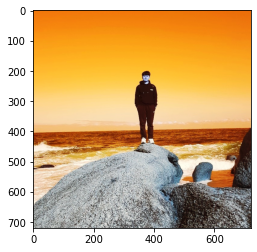

In [3]:
img_path = '/gdrive/MyDrive/Colab Notebooks/Explolation/exploration_8/images/my_image2.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)
plt.imshow(img_orig)
plt.show()

### 1.2 세그멘테이션으로 사람 분리하기

In [4]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.
# preprocess()는 전처리로 input tensor를 만들 수 있습니다.
# run()은 실제로 세그멘테이션을 하는 함수

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# 사전에 학습된 가중치(pretrained weight)를 불러옵니다.
# 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드하고 DeepLabModel 을 초기화합니다.
# define model and download & load pretrained weight
# 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/gdrive/MyDrive/Colab Notebooks/Explolation/exploration_8/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /gdrive/MyDrive/Colab Notebooks/Explolation/exploration_8/models
model loaded successfully!


In [6]:
# 준비한 이미지를 네트워크에 입력합니다.
# 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max()

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(720, 720, 3) (513, 513, 3) 15


In [7]:
# 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같습니다.

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

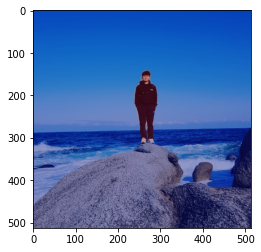

In [8]:
# 우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해본다.
# applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다.
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 1.3 세그멘테이션 결과를 원래 크기로 복원하기

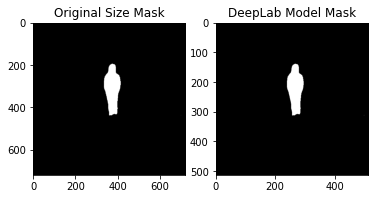

In [9]:
# cv2.resize() 함수를 이용
# 크기를 키울 때 보간(interpolation) 을 고려
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
# 보간법(interpolation) : 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다.
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [10]:
img_orig.shape

(720, 720, 3)

### 1.4 배경 흐리게 하기

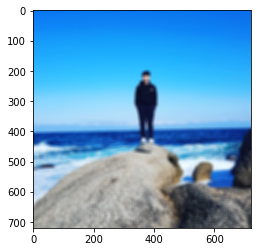

In [11]:
# blur()함수를 이용

img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

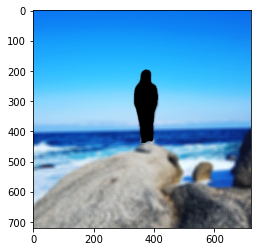

In [12]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
# bitwise_not 함수를 이용하면 이미지가 반전됩니다.
# 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1.5 흐린 배경과 원본 영상 합성

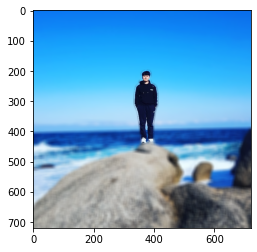

In [13]:
# 배경 영상과 사람 영상을 합치기
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다.

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 두번째 사진(크로마키)

### 2.1 사진준비

In [14]:
img_path2 = '/gdrive/MyDrive/Colab Notebooks/Explolation/exploration_8/images/my_image.jpg'
img_orig2 = cv2.imread(img_path2) 
print (img_orig2.shape)

(2736, 3648, 3)


In [15]:
# 크로마키 사진
img_path_cr = '/gdrive/MyDrive/Colab Notebooks/Explolation/exploration_8/images/forest.jpg'
img_cr = cv2.imread(img_path_cr)
print (img_cr.shape)

(360, 538, 3)


### 2.2 세그멘테이션으로 사람 분리하기

In [16]:
# 준비한 이미지를 네트워크에 입력합니다.
# 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max()

img_resized2, seg_map2 = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized2.shape, seg_map2.max())

(2736, 3648, 3) (384, 513, 3) 15


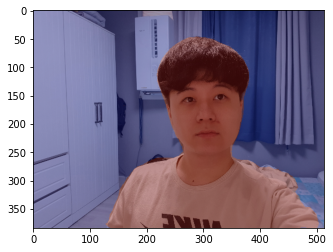

In [17]:
# 우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해본다.
# applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

img_show2 = img_resized2.copy()
seg_map2 = np.where(seg_map2 == 15, 15, 0) # 예측 중 사람만 추출
img_mask2 = seg_map2 * (255/seg_map2.max()) # 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다.
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

### 2.3 세그멘테이션 결과를 원래 크기로 복원하기

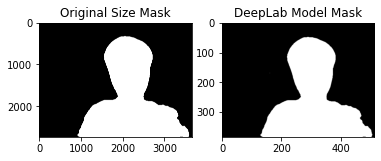

In [18]:
# cv2.resize() 함수를 이용
# 크기를 키울 때 보간(interpolation) 을 고려
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
# 보간법(interpolation) : 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다.
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.
img_mask_up2 = cv2.resize(img_mask2, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up2 = cv2.threshold(img_mask_up2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 2.4 배경 흐리게 하기

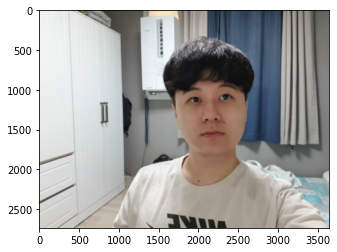

In [19]:
# blur()함수를 이용

img_orig_blur2 = cv2.blur(img_orig2, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# 크로마키로 사용할 사진을 resized 된 파일과 같은 shape로 만들어준다.

img_cr_re = cv2.resize(img_cr, img_resized2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
img_cr_re.shape

(384, 513, 3)

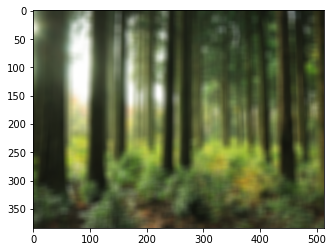

In [21]:
# 크로마키로 사용할 사진을 blur처리 해준다.

img_cr_blur = cv2.blur(img_cr_re, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_cr_blur, cv2.COLOR_BGR2RGB))
plt.show()

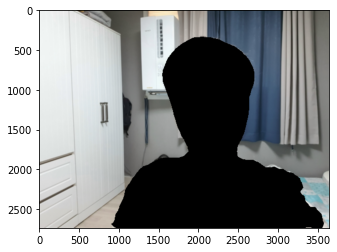

In [22]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
# bitwise_not 함수를 이용하면 이미지가 반전됩니다.
# 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

img_mask_color2 = cv2.cvtColor(img_mask_up2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

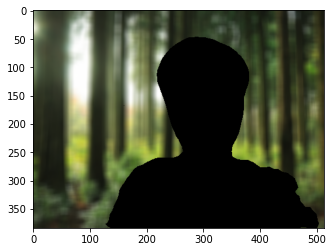

In [23]:
# 크로마키로 사용할 사진에서 세그멘테이션 마스크를 이용해서 배경만 추출한다.

img_mask_color22 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask22 = cv2.bitwise_not(img_mask_color22)
img_bg_blur22 = cv2.bitwise_and(img_cr_blur, img_bg_mask22)
cropped_cr = cv2.cvtColor(img_bg_blur22, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_cr)
plt.show()

### 2.5 흐린 배경과 원본 영상 합성

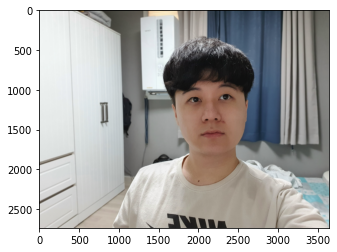

In [24]:
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

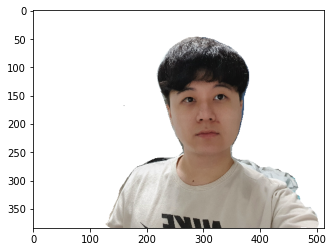

In [25]:
# mask 부분만 추출한다.

img_concat_re = np.where(img_mask_color22==255, img_resized2, 255)
cropped_my_img = cv2.cvtColor(img_concat_re, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_my_img)
plt.show()

#### 2.5.1 합성

1. mask 부분만 추출한다.
2. 크로마키로 사용할 배경의 size를 변경한다.
3. 크로마키로 사용할 배경에 mask 부분을 비운다.
4. 추출한 mask를 크로마키로 사용할 배경에 붙인다.
5. 크로마키로 사용할 배경을 원래 크기로 resize 한다.

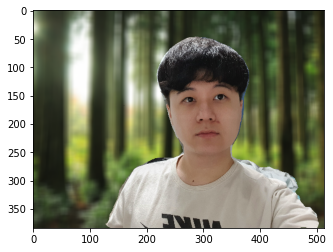

In [26]:
# 추출한 마스크 부분을 크로마키 배경에 붙여준다.

img_concat22_re = np.where(img_mask_color22==255, img_resized2, img_bg_blur22)
img_f = cv2.cvtColor(img_concat22_re, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(img_concat22_re, cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
img_cr_return = cv2.resize(img_f, img_cr.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
img_cr_return.shape

(360, 538, 3)

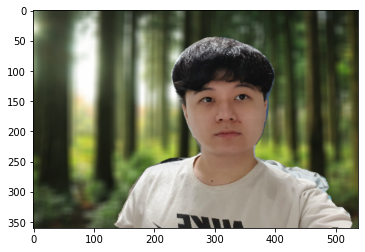

In [28]:
plt.imshow(img_cr_return)
plt.show()

## 3. 세번째 사진 (동물)

### 3.1 사진준비 

In [29]:
img_path3 = '/gdrive/MyDrive/Colab Notebooks/Explolation/exploration_8/images/star.jpg'
img_orig3 = cv2.imread(img_path3) 
print (img_orig3.shape)

(1280, 960, 3)


### 3.2 세그멘테이션으로 강아지 분리하기

In [30]:
img_resized3, seg_map3 = MODEL.run(img_orig3)
print (img_orig3.shape, img_resized3.shape, seg_map3.max())

(1280, 960, 3) (513, 384, 3) 12


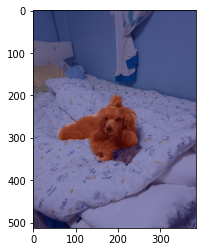

In [31]:
img_show3 = img_resized3.copy()
seg_map3 = np.where(seg_map3 == 12, 12, 0) # 예측 중 강아지만 추출
img_mask3 = seg_map3 * (255/seg_map3.max()) # 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다.
img_mask3 = img_mask3.astype(np.uint8)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

### 3.3 세그멘테이션 결과를 원래 크기로 복원하기

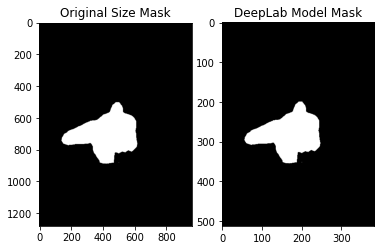

In [32]:
img_mask_up3 = cv2.resize(img_mask3, img_orig3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up3 = cv2.threshold(img_mask_up3, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up3, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 3.4 배경 흐리게 하기

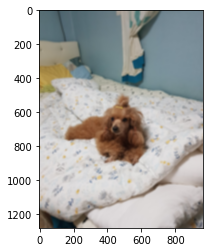

In [33]:
# blur()함수를 이용

img_orig_blur3 = cv2.blur(img_orig3, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

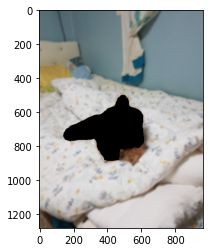

In [34]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
# bitwise_not 함수를 이용하면 이미지가 반전됩니다.
# 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

img_mask_color3 = cv2.cvtColor(img_mask_up3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

### 3.5 흐린 배경과 원본 영상 합성

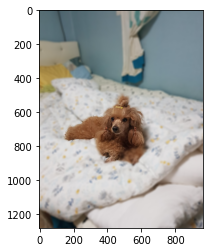

In [35]:
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 회고

- google colab으로 작업을 해 보았다. google colab에서는 cv가 잘 작동하지 않아서 생각보다 표현할 수 있는 범위가 적어서 아쉬웠다.
- 시간이 부족해서 새로운 플랫폼에서 작업을 못한점이 아쉬웠다. 프로젝트 제출 후 개인적으로 다양한 방법을 시도해 보고 싶은 프로젝트 였다.